In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 初始化參數並開始計算
NofChannel = 1  # 渠道數量
LofChannel = 140  # 渠道長度（公尺）
NofReach = 1400  # 每條渠道的區段數量
Mn = [0.03]  # 曼寧係數
InitialElev = [100.0]  # 渠道上游起始高程
InitialLev_ds = [99.9]  # 渠道下游起始高程
BottomSlope = [0.005]
BottomWidth = [10.0]
dx = LofChannel / NofReach  # 區段的均勻長度
YUP = 1.261  # 上游邊界條件
YDS = 0.972  # 下游邊界條件
G = 9.81  # 重力加速度
Q0 = 30  # 流量

# 初始化矩陣
NofUnknowns = (NofReach + 1) * NofChannel
F = np.zeros((NofUnknowns, 1)).ravel()  # 未知數
DY = np.zeros((NofUnknowns, 1)).ravel()  # 未知數
DF = np.zeros((NofUnknowns, NofUnknowns))  # 雅可比矩陣
Elev = np.zeros((NofChannel, NofReach + 1))  # 高程矩陣

# 設定初始高程和水位猜測值
for i in range(NofChannel):
    for j in range(NofReach + 1):
        Elev[i, j] = InitialElev[i] - dx * BottomSlope[i] * j
Y = np.ones((NofChannel, NofReach + 1)) * YUP  # 初始猜測值

# 計算矩形截面的通用參數
def dpdy():
    value = 2
    return value

def area(y, b):
    return b * y

def wetp(y, b):
    return b + 2 * y

def topWidth(b):
    return b

# calculate items in matrix
# cId: channel ID sectionId: section
def energy(cId, sectionId): # 00wabs(00) is necessary to deal flow direction
    return Y[cId, sectionId]+ Elev[cId, sectionId]+ Q0*abs(Q0)/2/G/area(Y[cId, sectionId], BottomWidth[cId])**2

def energyloss(cId, sectionId): # Use A/P instead of R
    return Q0*abs(Q0)*Mn[cId]**2/area(Y[cId, sectionId], BottomWidth[cId])**(10/3)*wetp(Y[cId, sectionId], BottomWidth[cId])**(4/3)

def dRdy(cId, sectionId):
    return topWidth(BottomWidth[cId])/wetp(Y[cId, sectionId], BottomWidth[cId])- \
    area(Y[cId, sectionId], BottomWidth[cId])/wetp(Y[cId, sectionId], BottomWidth[cId])**2*dpdy()

def dfdy1(cId, sectionId):
    return -1+Q0**2*(topWidth(BottomWidth[cId])/G/area(Y[cId, sectionId], BottomWidth[cId])**3- \
    2*Mn[cId]**2*dx/3/area(Y[cId, sectionId], BottomWidth[cId])**(13/3) * \
    wetp(Y[cId, sectionId], BottomWidth[cId])**(7/3)*dRdy(cId, sectionId) - \
    Mn[cId]**2*topWidth(BottomWidth[cId])*dx/area(Y[cId, sectionId], BottomWidth[cId])**(13/3)* \
    wetp(Y[cId, sectionId],BottomWidth[cId])**(4/3))

def dfdy2(cId, sectionId):
    return 1-Q0**2*(topWidth(BottomWidth[cId])/G/area(Y[cId, sectionId], BottomWidth[cId])**3+ \
    2*Mn[cId]**2*dx/3/area(Y[cId, sectionId], BottomWidth[cId])**(13/3) * \
    wetp(Y[cId, sectionId], BottomWidth[cId])**(7/3)*dRdy(cId, sectionId) + \
    Mn[cId]**2*topWidth(BottomWidth[cId])*dx/area(Y[cId,sectionId], BottomWidth[cId])**(13/3)* \
    wetp(Y[cId, sectionId], BottomWidth[cId])**(4/3))



In [172]:
# 迭代設定
maxIter = 0

while (maxIter < 100):
    channelId = 0
    nEQ = 0  # 方程式的 ID
    
    # 上游邊界條件
    F[nEQ] = Y[channelId, nEQ] - YUP
    DF[nEQ, nEQ] = 1
    
    nEQ += 1
    
    
    
    # 生成 AX = B
    for i in range(NofReach):
        # 計算 f
        F[nEQ] = energy(channelId, i + 1) - energy(channelId, i) + \
                0.5 * dx * (energyloss(channelId, i + 1) + energyloss(channelId, i))
        DF[nEQ, nEQ - 1] = dfdy1(channelId, i)  # dfdY1
        DF[nEQ, nEQ] = dfdy2(channelId, i + 1)  # dfdY2
        
        nEQ += 1
    # 使用線性代數庫求解非線性方程組
    # AX = F 找出 X
    DY = np.linalg.solve(DF, -F)  # 求解矩陣
    k = 0

    # 更新 Y 值
    for i in range(NofChannel):
        for j in range(NofReach + 1):
            Y[i, j] = Y[i, j] + DY[k]  # 使用 DY 更新 Y 值
            k += 1

    # 檢查收斂條件
    check = (abs(DY) < 0.0001).sum()  # 將收斂條件設為 0.0001

    if check >= NofUnknowns:
        break  # 若所有未知數都滿足收斂條件，則跳出迴圈
    else:
        maxIter += 1  # 否則，增加迭代計數

print("No. of Iter =", maxIter)  # 顯示迭代次數

No. of Iter = 4


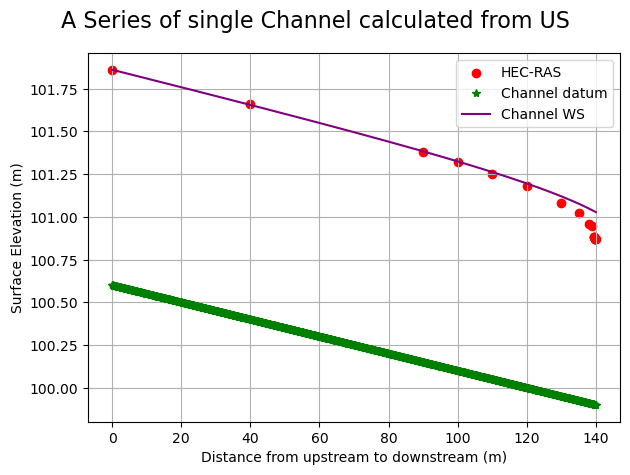

In [173]:
# 設定測試點
N = NofReach + 1
x1 = np.linspace(0, 140, N)
d1 = np.zeros(N)
ws1 = np.zeros(N)

d2 = np.zeros(17)
ws2 = np.zeros(17)

for i in range(N):
    d1[i] = 100.6 - dx * BottomSlope[0] * i
    ws1[i] = d1[i] + Y[0, i]

# HEC-RAS 結果
# hec_x = np.array([0,40,90,100,110,120,130,135,138,139,139.4,139.6,139.8,140])
hec_x = np.array([140.0,139.9,139.8,139.7,139.6,139.5,139.4,139,138,135,130,120,110,100,90,40,0])
hec_y = np.array([0.97,0.97,0.97,0.97,0.98,0.98,0.98,1.04,1.05,1.1,1.13,1.18,1.2,1.22,1.23,1.26,1.26])

for i in range(17):
    d2[i] = 100.6 - hec_x[i] * BottomSlope[0]
    ws2[i] = d2[i] + hec_y[i]

# 繪製圖表
fig, ax = plt.subplots()
ax.scatter(hec_x, ws2, color='red')
ax.plot(x1, d1, '*', color='green')
ax.plot(x1, ws1, '-', color='purple')
ax.set_xlabel('Distance from upstream to downstream (m)')
ax.set_ylabel('Surface Elevation (m)')
ax.legend(['HEC-RAS','Channel datum', 'Channel WS'])# 
fig.suptitle("A Series of single Channel calculated from US", fontsize=16)
fig.tight_layout()
plt.grid(True)
plt.show()


In [174]:
#from downstream sides
for i in range(NofChannel):
    for j in range(NofReach+1):
        Elev[i,j]= InitialElev[i]-dx * BottomSlope[i]*j
Y=np.ones((NofChannel,NofReach+1))*YDS
F=np.zeros((NofUnknowns,1)).ravel()
DY=np.zeros((NofUnknowns,1)).ravel()
DF=np.zeros((NofUnknowns,NofUnknowns))   
maxIter = 0

while (maxIter < 100):
    channelId = 0
    nEQ = 0  # 方程式的 ID
    '''
    # 上游邊界條件
    F[nEQ] = Y[channelId, nEQ] - YUP
    DF[nEQ, nEQ] = 1
    
    nEQ += 1
    '''
    
    
    # 生成 AX = B
    for i in range(NofReach):
        # 計算 f
        F[nEQ] = energy(channelId, i + 1) - energy(channelId, i) + \
                0.5 * dx * (energyloss(channelId, i + 1) + energyloss(channelId, i))
        DF[nEQ, nEQ] = dfdy1(channelId, i)  # dfdY1
        DF[nEQ, nEQ +1] = dfdy2(channelId, i + 1)  # dfdY2
        
        nEQ += 1
        
    #downstream bc
    F[nEQ] = Y[channelId, nEQ] - YDS
    DF[nEQ, nEQ] = 1
    
    # 使用線性代數庫求解非線性方程組
    # AX = F 找出 X
    DY = np.linalg.solve(DF, -F)  # 求解矩陣
    k = 0

    # 更新 Y 值
    for i in range(NofChannel):
        for j in range(NofReach + 1):
            Y[i, j] = Y[i, j] + DY[k]  # 使用 DY 更新 Y 值
            k += 1

    # 檢查收斂條件
    check = (abs(DY) < 0.0001).sum()  # 將收斂條件設為 0.0001

    if check >= NofUnknowns:
        break  # 若所有未知數都滿足收斂條件，則跳出迴圈
    else:
        maxIter += 1  # 否則，增加迭代計數

print("No. of Iter =", maxIter)  # 顯示迭代次數     

No. of Iter = 6


    Distance (hec_x)  Water Surface Elevation (ws2)  \
0              140.0                       100.8700   
1              139.9                       100.8705   
2              139.8                       100.8710   
4              139.6                       100.8820   
5              139.5                       100.8825   
6              139.4                       100.8830   
7              139.0                       100.9450   
8              138.0                       100.9600   
9              135.0                       101.0250   
10             130.0                       101.0800   
11             120.0                       101.1800   
12             110.0                       101.2500   
13             100.0                       101.3200   
14              90.0                       101.3800   
15              40.0                       101.6600   
16               0.0                       101.8600   

    Water Surface Elevation (ws1)  
0                      100.8

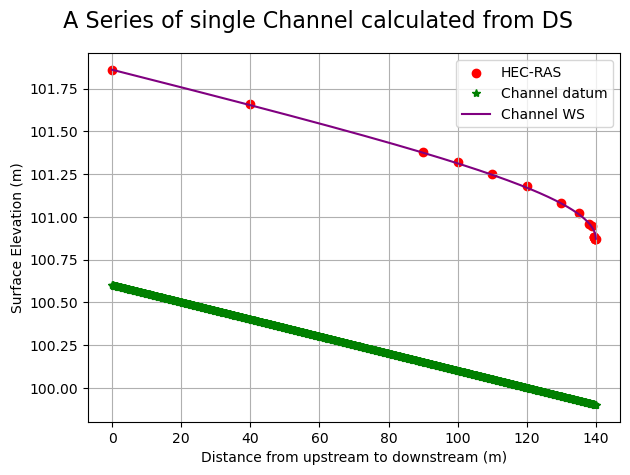

In [175]:
# 設定測試點
N = NofReach + 1
x1 = np.linspace(0, 140, N)
d1 = np.zeros(N)
ws1 = np.zeros(N)

d2 = np.zeros(17)
ws2 = np.zeros(17)

for i in range(N):
    d1[i] = 100.6 - dx * BottomSlope[0] * i
    ws1[i] = d1[i] + Y[0, i]

# HEC-RAS 結果
hec_x = np.array([140.0,139.9,139.8,139.7,139.6,139.5,139.4,139,138,135,130,120,110,100,90,40,0])
hec_y = np.array([0.97,0.97,0.97,0.97,0.98,0.98,0.98,1.04,1.05,1.1,1.13,1.18,1.2,1.22,1.23,1.26,1.26])

for i in range(17):
    d2[i] = 100.6 - hec_x[i] * BottomSlope[0]
    ws2[i] = d2[i] + hec_y[i]

# 繪製圖表

data = pd.DataFrame({
    'Distance (hec_x)': hec_x,
    'Water Surface Elevation (ws2)': ws2
})

# 打印 DataFrame
# print(data)
# 創建一個 DataFrame 來存放 HEC-RAS 和模擬結果
data = pd.DataFrame({'Distance (hec_x)': hec_x, 'Water Surface Elevation (ws2)': ws2})

# 匹配距離並添加模擬結果的 ws1
data['Water Surface Elevation (ws1)'] = data['Distance (hec_x)'].apply(
    lambda x: ws1[np.where(x1 == x)[0][0]] if x in x1 else None
)

# 篩選出同時有 hec_x 和 x1 對應的數據
filtered_data = data.dropna()

# 打印結果
print(filtered_data)

fig, ax = plt.subplots()
ax.scatter(hec_x, ws2, color='red')
ax.plot(x1, d1, '*', color='green')
ax.plot(x1, ws1, '-', color='purple')
ax.set_xlabel('Distance from upstream to downstream (m)')
ax.set_ylabel('Surface Elevation (m)')
ax.legend(['HEC-RAS', 'Channel datum', 'Channel WS'])
fig.suptitle(" A Series of single Channel calculated from DS", fontsize=16)
fig.tight_layout()
plt.grid(True)
plt.show()
